# 100-year Geoelectric Hazard Analysis for the United States

Authors: G. M. Lucas, J. J. Love, A. Kelbert, P. A. Bedrosian, E. J. Rigler

Notebook/Code Author: Greg Lucas (greg.lucas@lasp.colorado.edu)


This is a notebook containing the methods for producing the hazard analysis and maps for the article. All data and code used here is open-source and freely available to download/use. I have tried to give descriptions where you'll need to get data and store it locally where appropriate.

There are several python package dependencies used below that you may need to install if you don't already have them. I have created a package called bezpy, which I make heavy use of here to manipulate all of the data. It can be found here, along with installation instructions: [bezpy](https://github.com/greglucas/bezpy)
There is also an SECS package that can be found here: [pySECS](https://github.com/greglucas/pySECS)

In [1]:
import os
import warnings
# Some libraries warn excessively
warnings.filterwarnings('ignore')
import glob
import time
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

# %matplotlib widget
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

import shapely

plt.style.use(['seaborn-paper', 'tex'])

# Local Imports
import bezpy

## Statistical Analysis Functions
Using a Python code called [powerlaw](https://github.com/jeffalstott/powerlaw) for fitting powerlaw/lognormal functions to the data:.

In [2]:
import powerlaw
import scipy

erf = scipy.special.erf
erfinv = scipy.special.erfinv

def lognormal_ppf(y, mu, sigma, xmin):
    Q = erf( (np.log(xmin) - mu) / (np.sqrt(2)*sigma) )
    Q = Q*y - y + 1.0
    Q = erfinv(Q)
    return np.exp(mu + np.sqrt(2)*sigma*Q)

def fit_data(data):
    with np.errstate(all='ignore'), warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fit = powerlaw.Fit(data, xmin=np.min(data), verbose=False)
        
    fitting_func = fit.lognormal
    if np.any(np.isnan(fitting_func.cdf())):
        warnings.warn("No lognormal fit (changing to positive)")
        fitting_func = fit.lognormal_positive
        
    return fitting_func

def calc_100_year(fitting_func, nyears=31):
    ndata = len(fitting_func.parent_Fit.data)
    if ndata == 0:
        return np.nan

    x100 = 1-0.01*nyears/ndata
    y100 = lognormal_ppf(1-x100,
                         fitting_func.mu,
                         fitting_func.sigma,
                         xmin=fitting_func.xmin)
    # Get rid of inf's
    if ~np.isfinite(y100):
        return np.nan
    
    return y100

## Map Setup
I am using [Cartopy](https://github.com/SciTools/cartopy) for the geographic plotting

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Data is lat/lon unless specifically different
proj_data = ccrs.PlateCarree()
projection = ccrs.LambertConformal(central_latitude=30, central_longitude=-96)

def add_features_to_ax(ax):
    land_alpha = 0.7
    scale = '10m'
    # 10m oceans are super slow...
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='slategrey', alpha=0.65, zorder=-1)
    ax.add_feature(cfeature.LAND.with_scale(scale), facecolor='k', alpha=land_alpha, zorder=0)
    ax.add_feature(cfeature.STATES.with_scale(scale), edgecolor='w', alpha=land_alpha, zorder=0)
    ax.add_feature(cfeature.LAKES.with_scale(scale), facecolor='slategrey', alpha=0.25, zorder=0)

## Geographic Processing Tools
These are routines for processing the data from geopandas dataframes that relate to the transmission line datasets

In [4]:
def get_intersections(df, lon_bounds, lat_bounds):
    spatial_index = df.sindex

    x0, x1 = lon_bounds
    y0, y1 = lat_bounds
    polygon = shapely.geometry.Polygon([[x0, y0], [x1, y0], [x1, y1], [x0, y1]])

    possible_matches_index = list(spatial_index.intersection(polygon.bounds))
    possible_matches = df.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(polygon)]
    return precise_matches

def get_intersection_polygon(df, polygon):
    spatial_index = df.sindex
    possible_matches_index = list(spatial_index.intersection(polygon.bounds))
    possible_matches = df.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(polygon)]
    return precise_matches

def symlog(x):
    """Returns the symmetric log10 value, allowing for negatives"""
    return np.sign(x) * np.log10(np.abs(x))

def scale_vectors(x, y, scale=np.log10):
    """Scale vectors while preserving the angle.
    
    Parameters
    ==========
    x: Cartesian x coordinate(s)
    y: Cartesian y coordinate(s)
    
    scale: function to scale the magnitude by (Default: log10)"""
    mag = np.sqrt(x**2 + y**2)
    angle = np.arctan2(y, x)
    newx = scale(mag)*np.cos(angle)
    newy = scale(mag)*np.sin(angle)
    
    return (newx, newy)

US_lon_bounds = (-125, -66)
US_lat_bounds = (24, 50)

lon_bounds = US_lon_bounds
plot_lon_bounds = (lon_bounds[0] + 5, lon_bounds[1] - 5)
lat_bounds = US_lat_bounds

This is a generic boundary of the region where MT data is available.

In [5]:
US_shape = [[-126, 50], [-66, 50], [-66,23], [-84, 23], [-84, 30], [-88,36], [-98, 38], [-126, 38], [-126, 50]]
US_shape = shapely.geometry.Polygon(US_shape)

## Data files and directories

### Transmission Lines
Downloaded from the DHS Website:
[https://hifld-geoplatform.opendata.arcgis.com/](https://hifld-geoplatform.opendata.arcgis.com/)

There is a download for a shapefile called 'Electric_Power_Transmission_Lines.shp' on that website that you need.

### Impedance Tensors
Downloaded from the doi repository:
[doi:10.17611/DP/EMTF/USARRAY/TA](https://doi.org/10.17611/DP/EMTF/USARRAY/TA)

I downloaded all of the impedance tensors and have stored them in directories based upon the Survey's they were conducted during. You will just need to modify the code pointing to where these are downloaded later on if you have a different directory structure.

### Dst Data
Downloaded from the World Data Center:
(http://wdc.kugi.kyoto-u.ac.jp/dstdir/)[http://wdc.kugi.kyoto-u.ac.jp/dstdir/]

### Magnetic Field
Downloaded from the USGS Geomagnetism Program:
[https://geomag.usgs.gov](https://geomag.usgs.gov)

Downloaded from the NRCan Geomagnetism Program:
[http://www.geomag.nrcan.gc.ca/](http://www.geomag.nrcan.gc.ca/)

These are sometimes tedious to download for historic data. There are FTP servers for more recent data, which you can set up scripts for. I have downloaded all of the IAGA files, and converted them into binary netcdf files that can be read by xarray for much faster read/write times and smaller disk storage space. You will need to update the reader to point to your specific data files where appropriate.

In [6]:
fig_loc = "../figs/"
data_loc = "../data/"
trans_lines_file = data_loc + "Electric_Power_Transmission_Lines/Electric_Power_Transmission_Lines.shp"
MT_data_folder = data_loc + "MT_data/"
dst_data_file = data_loc + "dst_hourly_1957-2017.iaga"
kp_data_file = data_loc + "kp_ap.csv"
mag_field_folder = data_loc + "Bfields/"

## MT Sites
Read in all of the MT data and save the ones within the requested bounds

In [7]:
# Get all sub folders downloaded from the USArray website
xml_files = sorted(glob.glob(MT_data_folder + "MT_TF*/*.xml"))

MT_sites = []
site_xys = []

for fname in xml_files:
    
    site = bezpy.mt.read_xml(fname)
    # Only keep within our bounds
    if site.longitude < lon_bounds[0] or site.longitude > lon_bounds[1] or \
       site.latitude < lat_bounds[0] or site.latitude > lat_bounds[1]:
        continue
    
    if site.rating < 3:
        continue
        
    MT_sites.append(site)
    site_xys.append((site.latitude, site.longitude))
    
site_xys = np.array(site_xys)
print("There are {0} MT sites out of {1} total possible".format(len(MT_sites), len(xml_files)))

site_index_lookup = {site.name: i for i, site in enumerate(MT_sites)}
iVAQ58 = site_index_lookup['VAQ58']
iMEE62 = site_index_lookup['MEE62']
iCOP24 = site_index_lookup['COP24']
iCOP25 = site_index_lookup['COP25']
iCTI60 = site_index_lookup['CTI60']

There are 1079 MT sites out of 1179 total possible


## Transmission Lines

In [8]:
df = gpd.read_file(trans_lines_file)
# Change all MultiLineString into LineString objects by grabbing the first line
# Will miss a few coordinates, but should be OK as an approximation
df.loc[df["geometry"].apply(lambda x: x.geometryType()) == "MultiLineString","geometry"] = \
    df.loc[df["geometry"].apply(lambda x: x.geometryType()) == "MultiLineString","geometry"].apply(lambda x: x[0])

# Get rid of erroneous 1MV and low power line voltages
df = df[(df["VOLTAGE"] >= 100)]

# Limit it to where EarthScope data is found
df = get_intersection_polygon(df, US_shape)

# Print out the size of the dataframe so far
print("Number of transmission lines: {0}".format(len(df)))

Number of transmission lines: 17853


Creating `bezpy` transmission line objects that have some additional capabilities like integration with them.

In [9]:
df["obj"] = df.apply(bezpy.tl.TransmissionLine, axis=1)
df["length"] = df.obj.apply(lambda x: x.length)

## Setting weights for transmission line integration
Sets weights from MT sites to transmission lines with a Delaunay triangular interpolation. This can take several minutes

In [10]:
t1 = time.time()
#df.obj.apply(lambda x: x.set_nearest_sites(site_xys))
df.obj.apply(lambda x: x.set_delaunay_weights(site_xys))
print("Done filling interpolation weights: {0} s".format(time.time()-t1))

Done filling interpolation weights: 164.95283317565918 s


Remove lines with bad integration paths (outside of triangulation)

In [11]:
E_test = np.ones((1, len(site_xys), 2))

arr_delaunay = np.zeros(shape=(1, len(df)))
for i, tLine in enumerate(df.obj):
    arr_delaunay[:,i] = tLine.calc_voltages(E_test, how='delaunay')

df = df[~np.isnan(arr_delaunay[0, :])]

## Dst and Kp Data

In [12]:
dst_df = pd.read_csv(dst_data_file, index_col=0, infer_datetime_format=True, parse_dates=[[0,1]],
                     delim_whitespace=True, usecols=[0,1,3], names=["Date", "", "Dst"])
dst_df.index.name = "Date"

kp_df = pd.read_csv(kp_data_file, parse_dates=True, index_col=0)

dst_df['Kp'] = kp_df['1957':'2015']['Kp'].resample('1H').ffill()

In [13]:
storm_time_df = dst_df['1985':'2015'].copy()
storm_time_df['storm'] = False

delta_t = datetime.timedelta(days=1.5)

list_of_times = []

#for i in range(100):
curr_dst = -1000
while curr_dst < -140:
    dsts = storm_time_df[~storm_time_df['storm']]['Dst']
    dst_min = dsts.idxmin()
    storm_time_df.loc[dst_min-delta_t:dst_min+delta_t,'storm'] = True
    curr_dst = storm_time_df.loc[dst_min,'Dst']
    #print(dst_min, curr_dst)
    list_of_times.append(dst_min)
    
curr_kp = 10
while curr_kp >= 8:
    kp = storm_time_df[~storm_time_df['storm']]['Kp']
    kp_max = kp.idxmax()
    storm_time_df.loc[kp_max-delta_t:kp_max+delta_t,'storm'] = True
    curr_kp = storm_time_df.loc[kp_max,'Kp']
    #print(dst_min, curr_dst)
    list_of_times.append(kp_max)
    
print("Initial number of storms", len(list_of_times))

Initial number of storms 92


In [14]:
temp = storm_time_df['storm']
# first row is a True preceded by a False
fst = temp.index[temp & ~ temp.shift(1).fillna(False)]

# last row is a True followed by a False
lst = temp.index[temp & ~ temp.shift(-1).fillna(False)]

storm_times = []
for i in range(len(fst)):
    delta_t = lst[i]-fst[i]
    # Storm width in hours
    storm_hours = delta_t.days*24 + delta_t.seconds/3600
    if storm_hours < 3: continue
        
    storm_times.append((fst[i], lst[i]))
    
print("Number of storms after combining overlapping times:", len(storm_times))

Number of storms after combining overlapping times: 84


In [15]:
nDst = 0
nKp = 0
nBoth = 0
for x in storm_times:
    maxKp = storm_time_df.loc[x[0]:x[1]]['Kp'].max()
    minDst = storm_time_df.loc[x[0]:x[1]]['Dst'].min()
    if maxKp >= 8 and minDst <= -140:
        nBoth += 1
    elif maxKp >= 8:
        nKp += 1
    elif minDst <= -140:
        nDst += 1
    else:
        print("Error, shouldn't get here!", maxKp, minDst)
        
print("Number of events with both selections satisfied:", nBoth)
print("Number of events with only Kp satisfied:", nKp)
print("Number of events with only Dst satisfied:", nDst)

Number of events with both selections satisfied: 44
Number of events with only Kp satisfied: 5
Number of events with only Dst satisfied: 35


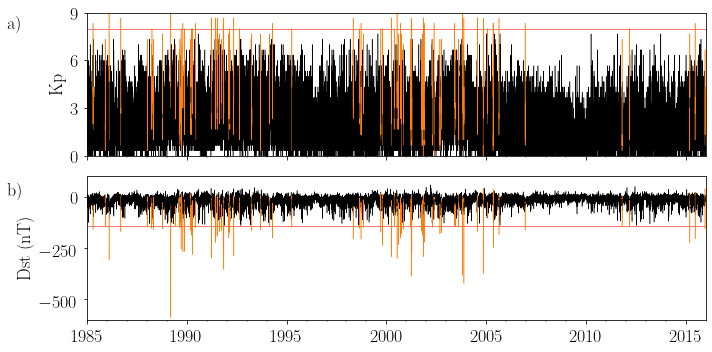

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 5))

stormy_data = storm_time_df[storm_time_df['storm']]
non_stormy_data = storm_time_df[~storm_time_df['storm']]

kp_storms = stormy_data['Kp'].resample('3H').max()
kp_no_storms = non_stormy_data['Kp'].resample('3H').max()
dst_storms = stormy_data['Dst'].resample('3H').min()
dst_no_storms = non_stormy_data['Dst'].resample('3H').min()


ax1.plot(kp_no_storms.index, kp_no_storms, c='k', linewidth=0.5)
ax1.plot(kp_storms.index, kp_storms, c='C1', linewidth=0.5)
    
ax1.set_ylim(0, 9)
ax1.set_yticks([0, 3, 6, 9])
ax1.axhline(8, c='r', zorder=-1, linewidth=0.5)
ax1.set_ylabel('Kp')
text_date = datetime.datetime(1981, 1, 1)
ax1.text(text_date, 8, 'a)', fontsize=18)


ax2.plot(dst_no_storms.index, dst_no_storms, c='k', linewidth=0.5)
ax2.plot(dst_storms.index, dst_storms, c='C1', linewidth=0.5)
    
ax2.set_ylim(-600, 100)
ax2.set_yticks([-500, -250, 0])
ax2.axhline(-140, c='r', zorder=-1, linewidth=0.5)
ax2.set_ylabel('Dst (nT)')
ax2.text(text_date, 8, 'b)', fontsize=18)

ax1.set_xlim(datetime.datetime(1985, 1, 1),  datetime.datetime(2015, 12, 31))
ticks = [datetime.datetime(1985, 1, 1), datetime.datetime(1990, 1, 1), datetime.datetime(1995, 1, 1),
         datetime.datetime(2000, 1, 1), datetime.datetime(2005, 1, 1), datetime.datetime(2010, 1, 1),
         datetime.datetime(2015, 1, 1)]
ax1.set_xticks(ticks)
ax1.xaxis.set_minor_locator(mpl.dates.YearLocator())
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
plt.tight_layout()

fig.savefig(fig_loc + 'kp_dst_plot.pdf', bbox_inches='tight')

## Read in Magnetic Field Files

In [17]:
obs_files = glob.glob(mag_field_folder + "/*_dmin.nc")
obs_dict = {os.path.basename(x)[:3]: xr.open_dataset(x) for x in obs_files}

print("Number of observatories:", len(obs_dict))

Number of observatories: 24


In [18]:
obs_xy = []
for name in obs_dict:
    dataset = obs_dict[name]
    obs_xy.append((dataset.Latitude, dataset.Longitude))

obs_xy = np.squeeze(np.array(obs_xy))

In [19]:
usgs_obs = ['bou', 'brw', 'bsl', 'cmo', 'ded', 'dlr', 'frd', 'frn', 'gua', 'hon', 'new',
            'shu', 'sit', 'sjg', 'tuc']
nrcan_obs = ['blc', 'cbb', 'fcc', 'mea', 'ott', 'res', 'stj', 'vic', 'ykc']

for name in usgs_obs + nrcan_obs:
    dataset = obs_dict[name]
    distances = bezpy.tl.haversine_distance(lon1=dataset.Longitude, lat1=dataset.Latitude,
                                            lon2=obs_xy[:,1], lat2=obs_xy[:,0])
    
    datestring1 = '1985-01-01'
    if np.datetime64(datetime.datetime(1985, 1, 1)) < dataset.Time[0].data:
        datestring1 = np.datetime_as_string(dataset.Time[0].data)[:10]
        
    datestring2 = '2015-12-31' 
    if np.datetime64(datetime.datetime(2015, 12, 31)) > dataset.Time[-1].data:
        datestring2 = np.datetime_as_string(dataset.Time[-1].data)[:10]
        
    print("  & {} & {:.2f} & {:.2f} & {:.2f} & {} & {} \\\\".format(name.upper(), dataset.Latitude, dataset.Longitude,
          np.min(distances[distances > 0]), datestring1, datestring2))

  & BOU & 40.14 & -105.24 & 1013.14 & 1985-01-01 & 2015-12-31 \\
  & BRW & 71.32 & -156.62 & 305.09 & 1985-01-01 & 2015-12-31 \\
  & BSL & 30.35 & -89.64 & 1082.83 & 1986-04-18 & 2015-12-31 \\
  & CMO & 64.87 & -147.86 & 610.72 & 1985-01-01 & 2015-12-31 \\
  & DED & 70.36 & -148.79 & 305.09 & 2011-01-01 & 2015-12-31 \\
  & DLR & 29.30 & -100.80 & 1001.28 & 1985-01-01 & 2007-12-31 \\
  & FRD & 38.20 & -77.37 & 814.46 & 1985-01-01 & 2015-12-31 \\
  & FRN & 37.09 & -119.72 & 986.57 & 1985-01-01 & 2015-12-31 \\
  & GUA & 13.59 & 144.87 & 6090.22 & 1985-01-01 & 2015-12-31 \\
  & HON & 21.32 & -158.00 & 3789.59 & 1985-01-01 & 2015-12-31 \\
  & NEW & 48.26 & -117.12 & 465.67 & 1985-01-01 & 2015-12-31 \\
  & SHU & 55.35 & -160.46 & 1263.69 & 2005-01-01 & 2015-12-31 \\
  & SIT & 57.06 & -135.33 & 1097.21 & 1985-01-01 & 2015-12-31 \\
  & SJG & 18.11 & -66.15 & 2485.69 & 1985-01-01 & 2015-12-31 \\
  & TUC & 32.17 & -110.73 & 986.57 & 1985-01-01 & 2015-12-31 \\
  & BLC & 64.32 & -96.01 & 626.41 & 

# Plot of all Datasets

In [20]:
COP24_loc = site_xys[iCOP24, ::-1]
COP25_loc = site_xys[iCOP25, ::-1]
VAQ58_loc = site_xys[iVAQ58, ::-1]
MEE62_loc = site_xys[iMEE62, ::-1]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


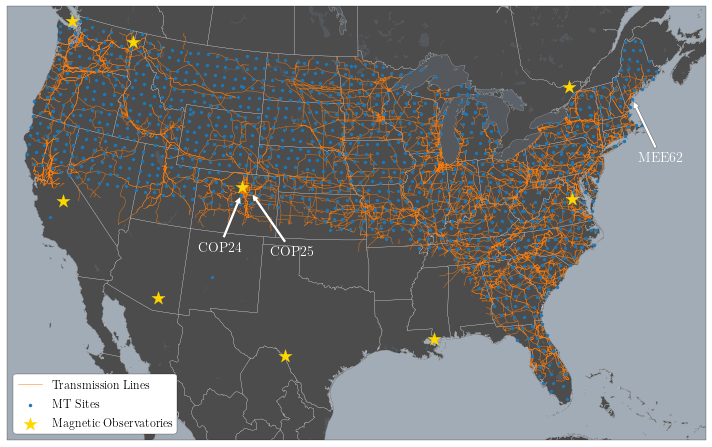

In [21]:
fig, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(10, 10))

ax.set_extent(plot_lon_bounds + lat_bounds, proj_data)
add_features_to_ax(ax)

# Transmission Lines
lines = [np.array(linestring)[:, :2] for linestring in df['geometry']]
coll = mpl.collections.LineCollection(lines)
coll.set_linewidth(0.5)
linecolor = 'tab:orange'
coll.set_color(linecolor)
coll.set_alpha(0.8)
coll.set_zorder(1)
coll.set_transform(proj_data)
ax.add_collection(coll)

ax.plot([], color=linecolor, linewidth=0.5, label='Transmission Lines')

# MT Sites
ax.scatter(site_xys[:,1], site_xys[:,0], s=10, c='tab:blue', label='MT Sites', zorder=2, transform=proj_data)

# Observatories
ax.scatter(obs_xy[:,1], obs_xy[:,0], s=200, marker='*', c='gold', label='Magnetic Observatories', zorder=3, transform=proj_data)


ax.legend(loc='lower left', fontsize=12, framealpha=1, fancybox=True, edgecolor='k')

# gl = ax.gridlines(crs=ccrs.PlateCarree(), # draw_labels=True,
#                   linewidth=1., color='k', alpha=0.75, linestyle='--', zorder=-1)

temp_transform = proj_data._as_mpl_transform(ax)
ax.annotate('COP24', xy=COP24_loc, xytext=(COP24_loc[0]-3, COP24_loc[1]-4),
            xycoords=temp_transform, color='w', fontsize=14,
            arrowprops=dict(facecolor='w', arrowstyle='simple'))
ax.annotate('COP25', xy=COP25_loc, xytext=(COP25_loc[0]+2, COP25_loc[1]-4),
            xycoords=temp_transform, color='w', fontsize=14,
            arrowprops=dict(facecolor='w', arrowstyle='simple'))
ax.annotate('MEE62', xy=MEE62_loc, xytext=(MEE62_loc[0]-1, MEE62_loc[1]-4),
            xycoords=temp_transform, color='w', fontsize=14,
            arrowprops=dict(facecolor='w', arrowstyle='simple'))
# gl.xlines = False
# gl.ylines = False

fig.savefig(fig_loc + 'datasets_overview.png', bbox_inches='tight', dpi=200)
# fig.savefig('datasets_overview.pdf')

## SECS Magnetic Field

In [22]:
from pySECS import SECS
R_earth = 6371e3

def calculate_SECS(B, obs_xy, pred_xy):
    """Calculate SECS output magnetic field
    
       B shape: (ntimes, nobs, 3 (xyz))
       
       obs_xy shape: (nobs, 2 (lat, lon))
       
       pred_xy shape: (npred, 2 (lat, lon))"""
    if obs_xy.shape[0] != B.shape[1]:
        raise ValueError("Number of observation points doesn't match B input")
        
    obs_lat_lon_r = np.zeros((len(obs_xy), 3))
    obs_lat_lon_r[:,0] = obs_xy[:,0]
    obs_lat_lon_r[:,1] = obs_xy[:,1]
    obs_lat_lon_r[:,2] = R_earth
    
    obs_var = np.ones(obs_lat_lon_r.shape)
    # Don't include Z component in fits for now
    obs_var[:,2] = np.inf
        
    # specify the SECS grid
    lat, lon, r = np.meshgrid(np.linspace(15,85,36), 
                              np.linspace(-175,-25,76),
                              R_earth+110000, indexing='ij')
    secs_lat_lon_r = np.hstack((lat.reshape(-1,1),
                                lon.reshape(-1,1),
                                r.reshape(-1,1)))
    
    secs = SECS(sec_df_loc=secs_lat_lon_r)

    secs.fit(obs_loc=obs_lat_lon_r, obs_B=B,
             obs_var=obs_var, epsilon=0.05)
    
    # Create prediction points
    pred_lat_lon_r = np.zeros((len(pred_xy), 3))
    pred_lat_lon_r[:,0] = pred_xy[:,0]
    pred_lat_lon_r[:,1] = pred_xy[:,1]
    pred_lat_lon_r[:,2] = R_earth
    
    B_pred = secs.predict_B(pred_lat_lon_r)
    
    return B_pred

In [23]:
# Only load data that we need.
obs_xy = []
B_obs = []

oneday = datetime.timedelta(days=1)
twoday = 2*oneday
march89_storm = datetime.datetime(1989, 3, 14, 1)
halloween_storm = datetime.datetime(2003, 10, 30, 1)
bastille_storm = datetime.datetime(2000, 7, 15, 1)
st_pattys_storm = datetime.datetime(2015, 3, 17)


event_time = march89_storm
start_time, end_time = event_time-twoday, event_time+twoday

B_frd = []

for name in obs_dict:
    dataset = obs_dict[name]

    data = dataset.loc[{'Time': slice(start_time, end_time)}].interpolate_na('Time')
    # No data here... skip ahead
    if len(data['Time']) == 0:
        continue
    #data = data.apply(lambda x: bezpy.mag.filter(x, sample_freq=1./60, highcut=1./60, lowcut=1./(10000)))
    data = np.array(data.loc[{'Time': slice(start_time, end_time)}].to_array().T)
    if np.any(np.isnan(data)):
        continue
    
    data = data - np.median(data, axis=0)
    obs_xy.append((dataset.Latitude, dataset.Longitude))
    B_obs.append(data)

obs_xy = np.squeeze(np.array(obs_xy))
B_obs = np.array(B_obs).swapaxes(0, 1)

# Leave One Out Testing

In [24]:
# Only load data that we need.
leave_one_out_results_B = {}
leave_one_out_results_E = {}

oneday = datetime.timedelta(days=1)
twoday = 2*oneday
march89_storm = datetime.datetime(1989, 3, 14, 1)
halloween_storm = datetime.datetime(2003, 10, 30, 1)
bastille_storm = datetime.datetime(2000, 7, 15, 1)


event_time = march89_storm
start_time, end_time = event_time-twoday, event_time+twoday

leave_one_out_obs = 'bou'
for leave_one_out_obs in ['new', 'ott', 'frd', 'bou']:
    obs_xy2 = []
    B_obs2 = []

    for name in obs_dict:
        # Testing leave one out with observatories
        if name == leave_one_out_obs:
            continue

        dataset = obs_dict[name]

        data = dataset.loc[{'Time': slice(start_time, end_time)}].interpolate_na('Time')
        # No data here... skip ahead
        if len(data['Time']) == 0:
            continue
        #data = data.apply(lambda x: bezpy.mag.filter(x, sample_freq=1./60, highcut=1./60, lowcut=1./(10000)))
        data = np.array(data.loc[{'Time': slice(start_time, end_time)}].to_array().T)
        if np.any(np.isnan(data)):
            continue

        data = data - np.median(data, axis=0)
        obs_xy2.append((dataset.Latitude, dataset.Longitude))
        B_obs2.append(data)

    obs_xy2 = np.squeeze(np.array(obs_xy2))
    B_obs2 = np.array(B_obs2).swapaxes(0, 1)
    leave_one_out_results_B[leave_one_out_obs] = B_obs2.copy()
    
    B_pred2 = calculate_SECS(B_obs2, obs_xy2, site_xys)

    E_pred2 = np.zeros((len(B_obs2), len(site_xys), 2))
    for i, site in enumerate(MT_sites):
        Ex, Ey = site.convolve_fft(B_pred2[:,i,0], B_pred2[:,i,1], dt=60)
        E_pred2[:,i,0] = Ex
        E_pred2[:,i,1] = Ey
        
    leave_one_out_results_E[leave_one_out_obs] = E_pred2.copy()

In [25]:
bou_site = obs_dict['bou']
bou_xy = np.array([[bou_site.Latitude, bou_site.Longitude]])
B_pred_bou = calculate_SECS(B_obs2, obs_xy2, bou_xy)

times = np.array(bou_site.loc[{'Time': slice(start_time, end_time)}]['Time'])
bou_data = bou_site.loc[{'Time': slice(start_time, end_time)}].interpolate_na('Time')

# bou_data = bou_data.apply(lambda x: bezpy.mag.filter_signal(x, sample_freq=1./60, highcut=1./60, lowcut=1./(10000)))
bou_data = np.array(bou_data.loc[{'Time': slice(start_time, end_time)}].to_array().T)

bou_data = bou_data - np.median(bou_data, axis=0)

bou_x_data = bou_site.loc[{'Time': slice(start_time, end_time)}]['X']
nan_times = np.where(np.isnan(bou_x_data))[0]

## SECS BOU Leave-one-out Time-series

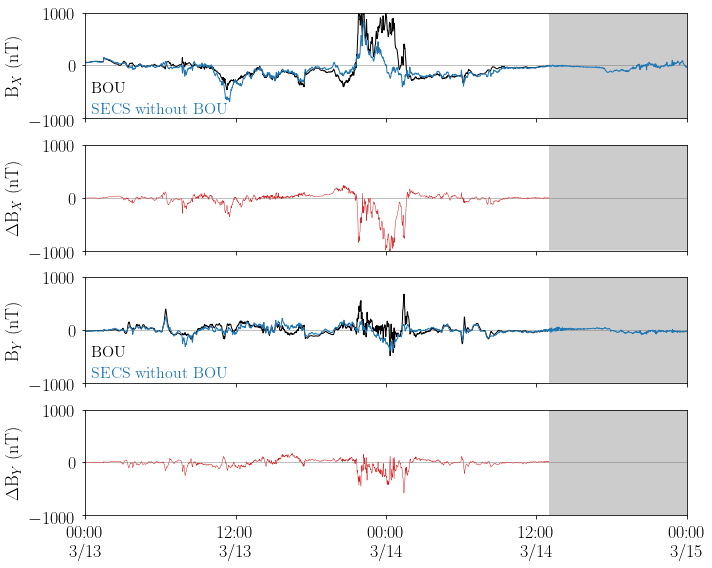

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(10, 8), nrows=4,
                               sharex=True, sharey=True)

for ax in [ax1, ax2, ax3, ax4]:
    ax.axhline(0., c='gray', linewidth=0.5)

diff = B_pred_bou - bou_data

begin_nan = nan_times[0]
ax2.plot(times[:begin_nan], (B_pred_bou[:, 0] - bou_data[:, 0])[:begin_nan], c='tab:red', alpha=1, linewidth=0.5)
ax1.plot(times[:begin_nan], bou_data[:begin_nan, 0], c='k', linewidth=1)
ax1.plot(times, B_pred_bou[:, 0], c='tab:blue', linewidth=1)

for ax in [ax1, ax2, ax3, ax4]:
    ax.fill_between(times[nan_times], -1000, 1000, facecolor='k', alpha=0.2)

ax4.plot(times[:begin_nan], (B_pred_bou[:, 1] - bou_data[:, 1])[:begin_nan], c='tab:red', alpha=1, linewidth=0.5)
ax3.plot(times[:begin_nan], bou_data[:begin_nan, 1], c='k', linewidth=1)
ax3.plot(times, B_pred_bou[:, 1], c='tab:blue', linewidth=1)

for ax in [ax1, ax3]:
    ax.text(datetime.datetime(1989, 3, 13, 0, 30), -500, "BOU", color='k', fontsize=16)
    ax.text(datetime.datetime(1989, 3, 13, 0, 30), -900, "SECS without BOU", color='tab:blue', fontsize=16)

ax1.set_ylim(-1000, 1000)
ax1.set_xlim(datetime.datetime(1989, 3, 13, 0, 0), datetime.datetime(1989, 3, 15, 0, 0))
ax1.set_xticks([datetime.datetime(1989, 3, 13, 0, 0), datetime.datetime(1989, 3, 13, 12, 0),
                datetime.datetime(1989, 3, 14, 0, 0), datetime.datetime(1989, 3, 14, 12, 0),
                datetime.datetime(1989, 3, 15, 0, 0)])
ax1.set_xticklabels(['00:00\n3/13', '12:00\n3/13',
                     '00:00\n3/14', '12:00\n3/14',
                     '00:00\n3/15'])

ax1.set_ylabel('B$_X$ (nT)')
ax2.set_ylabel('$\Delta$B$_X$ (nT)')
ax3.set_ylabel('B$_Y$ (nT)')
ax4.set_ylabel('$\Delta$B$_Y$ (nT)')

fig.savefig(fig_loc + 'SECS_{}_Comparison_4panel.pdf'.format(leave_one_out_obs), bbox_inches='tight')

### Prediction Step

In [27]:
B_pred = calculate_SECS(B_obs, obs_xy, site_xys)

E_pred = np.zeros((len(B_obs), len(site_xys), 2))
for i, site in enumerate(MT_sites):
    Ex, Ey = site.convolve_fft(B_pred[:, i, 0], B_pred[:, i, 1], dt=60)
    E_pred[:, i, 0] = Ex
    E_pred[:, i, 1] = Ey

In [28]:
B_pred2 = calculate_SECS(B_obs2, obs_xy2, site_xys)

E_pred2 = np.zeros((len(B_obs2), len(site_xys), 2))
for i, site in enumerate(MT_sites):
    Ex, Ey = site.convolve_fft(B_pred2[:,i,0], B_pred2[:,i,1], dt=60)
    E_pred2[:,i,0] = Ex
    E_pred2[:,i,1] = Ey

## E-field leave-one-out difference plots

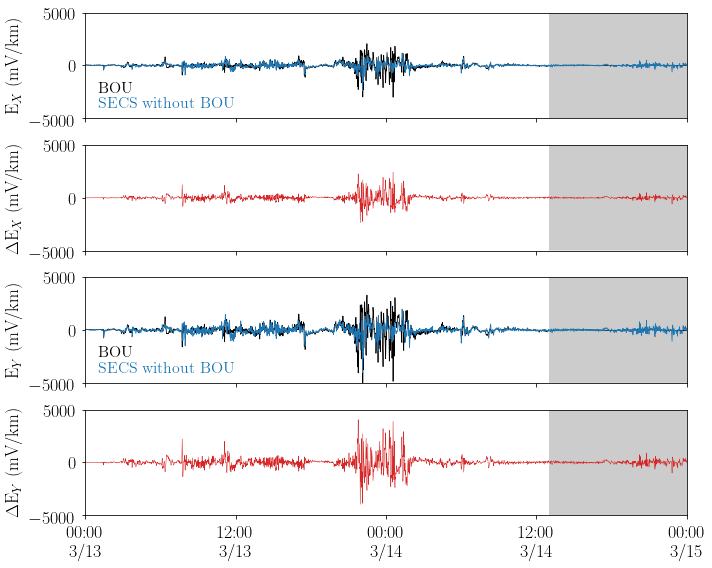

In [29]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(10, 8), nrows=4,
                               sharex=True, sharey=True)

diff = E_pred2 - E_pred

ylim = 5000
ax2.plot(times, diff[:, iCOP24, 0], c='tab:red', linewidth=0.5)
ax1.plot(times, E_pred[:, iCOP24, 0], c='k', linewidth=0.75)
ax1.plot(times, E_pred2[:, iCOP24, 0], c='tab:blue', linewidth=0.75)

for ax in [ax1, ax2, ax3, ax4]:
    ax.fill_between(times[nan_times], -ylim, ylim, facecolor='k', alpha=0.2)

ax4.plot(times, diff[:, iCOP24, 1], c='tab:red', linewidth=0.5)
ax3.plot(times, E_pred[:, iCOP24, 1], c='black', linewidth=0.75)
ax3.plot(times, E_pred2[:, iCOP24, 1], c='tab:blue', linewidth=0.75)


ax1.set_ylim(-ylim, ylim)
# ax1.set_xlim(start_time+oneday, end_time-oneday)
ax1.set_xlim(datetime.datetime(1989, 3, 13, 0, 0), datetime.datetime(1989, 3, 15, 0, 0))


ax1.set_xticks([datetime.datetime(1989, 3, 13, 0, 0), datetime.datetime(1989, 3, 13, 12, 0),
                datetime.datetime(1989, 3, 14, 0, 0), datetime.datetime(1989, 3, 14, 12, 0),
                datetime.datetime(1989, 3, 15, 0, 0)])
ax1.set_xticklabels(['00:00\n3/13', '12:00\n3/13',
                     '00:00\n3/14', '12:00\n3/14',
                     '00:00\n3/15'])

for ax in [ax1, ax3]:
    ax.text(datetime.datetime(1989, 3, 13, 1, 0), -2500, "BOU", color='k', fontsize=16)
    ax.text(datetime.datetime(1989, 3, 13, 1, 0), -4000, "SECS without BOU", color='tab:blue', fontsize=16)

ax1.set_ylabel('E$_X$ (mV/km)')
ax2.set_ylabel('$\Delta$E$_X$ (mV/km)')
ax3.set_ylabel('E$_Y$ (mV/km)')
ax4.set_ylabel('$\Delta$E$_Y$ (mV/km)')

fig.savefig(fig_loc + 'SECS_E_BOU_Comparison_4panel.pdf', bbox_inches='tight')

## Difference plots for 4 observatories

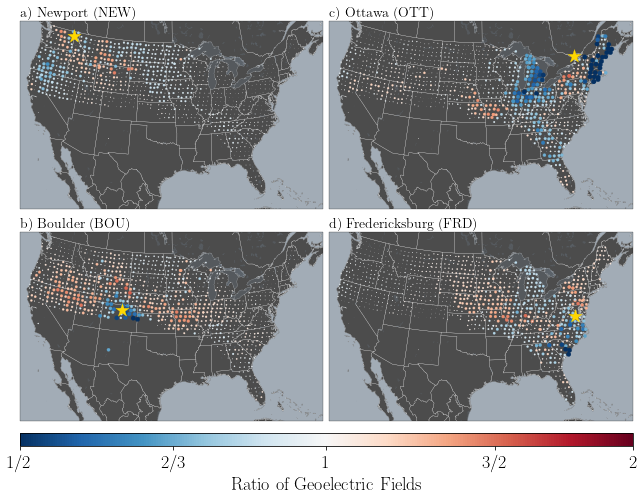

In [30]:
fig = plt.figure(figsize=(11, 8))

gs0 = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.06], hspace=0.02, wspace=0.02)
ax_cbar = plt.subplot(gs0[2, :]) # entire bottom

ax_new = plt.subplot(gs0[0, 0], projection=projection)
ax_bou = plt.subplot(gs0[1, 0], projection=projection)
ax_ott = plt.subplot(gs0[0, 1], projection=projection)
ax_frd = plt.subplot(gs0[1, 1], projection=projection)

cmap = plt.cm.get_cmap('RdBu_r')
# Percentage
# norm = mpl.colors.Normalize(vmin=-100, vmax=100)
# Ratio
norm = mpl.colors.PowerNorm(vmin=0.5, vmax=2, gamma=np.log(2)/np.log(3))

for obs, ax in [('new', ax_new), ('bou', ax_bou), ('ott', ax_ott), ('frd', ax_frd)]:
    add_features_to_ax(ax)
    ax.set_extent(plot_lon_bounds + lat_bounds, proj_data)
    E = np.sqrt(E_pred[:,:,0]**2 + E_pred[:,:,1]**2)
    E_pred2 = leave_one_out_results_E[obs]
    E2 = np.sqrt(E_pred2[:,:,0]**2 + E_pred2[:,:,1]**2)
    E_max = np.max(E, axis=0)/1000.
    E2_max = np.max(E2, axis=0)/1000.
    E_diff = (E2_max - E_max)/E_max
    E_diff = np.abs(E2_max/E_max)
    obs_loc = (obs_dict[obs].Longitude, obs_dict[obs].Latitude)
    sizes = np.abs(E_diff/np.abs(E_diff).max())
    s = norm(E_diff)
    sizes = np.abs((0.5 - s)) / 0.5

    ax.scatter(site_xys[:,1], site_xys[:,0], c=E_diff, s=sizes*20, cmap=cmap, norm=norm, transform=proj_data)
    ax.scatter(obs_loc[0], obs_loc[1], c='gold', marker='*', s=200, transform=proj_data)

font_properties = {'horizontalalignment': 'left', 'fontsize':14}
xtext, ytext = 0., 1.02
ax_new.text(xtext, ytext, 'a) Newport (NEW)', fontdict=font_properties, transform=ax_new.transAxes)
ax_bou.text(xtext, ytext, 'b) Boulder (BOU)', fontdict=font_properties, transform=ax_bou.transAxes)
ax_ott.text(xtext, ytext, 'c) Ottawa (OTT)', fontdict=font_properties, transform=ax_ott.transAxes)
ax_frd.text(xtext, ytext, 'd) Fredericksburg (FRD)', fontdict=font_properties, transform=ax_frd.transAxes)
#--------------------------------
# Colorbar
#--------------------------------
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# Set scalar mappable array
sm._A = []
cbar = mpl.colorbar.Colorbar(ax=ax_cbar, mappable=sm, orientation='horizontal',
                             ticklocation='bottom', ticks=[0.5, 2/3, 1, 1.5, 2])

cbar.ax.set_xticklabels(['1/2', '2/3', '1', '3/2', '2'])
cbar.set_label(r"Ratio of Geoelectric Fields", size=18)
fig.savefig(fig_loc + 'Geoelectric_field_1989_diff_4panel.png'.format(leave_one_out_obs.upper()), bbox_inches='tight', dpi=200)

# Calculations
 - E-fields at each MT site
 - Integration of voltages

In [31]:
n_trans_lines = len(df)
mag_times = pd.date_range(start=start_time, end=end_time, freq='1Min')
n_times = len(mag_times)

models = {"MT": MT_sites}

In [32]:
t0 = time.time()
results_dict = {}

E_pred = np.zeros((n_times, len(site_xys), 2))
for i, site in enumerate(MT_sites):
    Ex, Ey = site.convolve_fft(B_pred[:,i,0], B_pred[:,i,1], dt=60)
    E_pred[:,i,0] = Ex
    E_pred[:,i,1] = Ey
print("Done calculating E-fields: {0} s".format(time.time()-t0))

arr_delaunay = np.zeros(shape=(n_times, n_trans_lines))
for i, tLine in enumerate(df.obj):
    if i % 1000 == 0:
        print(i, ':', time.time()-t0, 's')
    arr_delaunay[:,i] = tLine.calc_voltages(E_pred, how='delaunay')

df_voltage_delaunay = pd.DataFrame(index=mag_times, columns=df.index, data=arr_delaunay)
    
print("Done with all calculations: {0} s".format(time.time()-t0))

Done calculating E-fields: 3.9813361167907715 s
0 : 3.98341703414917 s
1000 : 26.876318216323853 s
2000 : 45.242855072021484 s
3000 : 65.12509989738464 s
4000 : 87.35294723510742 s
5000 : 106.75771403312683 s
6000 : 125.89638590812683 s
7000 : 147.25929427146912 s
8000 : 165.9372799396515 s
9000 : 184.00845193862915 s
10000 : 198.82652807235718 s
11000 : 219.18725323677063 s
12000 : 244.95241689682007 s
13000 : 274.22078824043274 s
14000 : 306.3720951080322 s
15000 : 343.2745101451874 s
16000 : 375.97957706451416 s
17000 : 415.84871912002563 s
Done with all calculations: 428.8392460346222 s


In [33]:
t = 2670 # 1989/03/13 21:30
t = 2880 # 1989/03/14 01:00
t = 2700 # 1989/03/14 01:00

df_voltage = df_voltage_delaunay
voltages = np.ma.masked_invalid(df_voltage.iloc[t,:].abs())
line_resistivity = 1
line_E = voltages/(line_resistivity*df['length'].values)

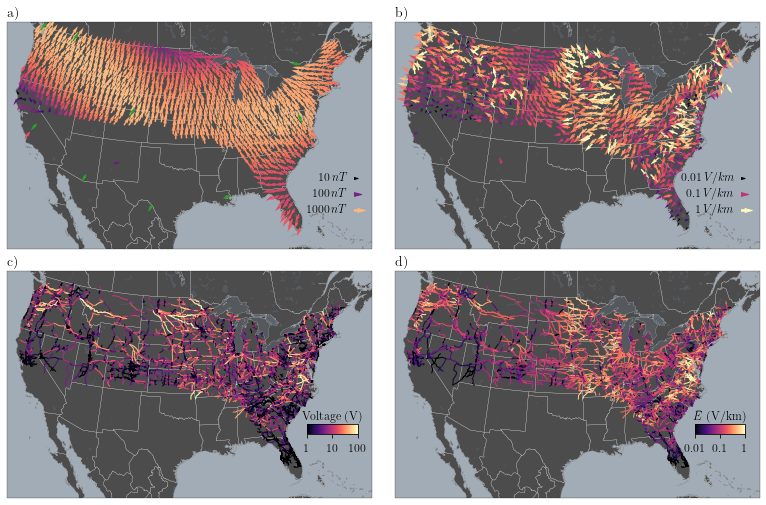

In [34]:
fig = plt.figure(figsize=(11*1.25, 7*1.25))

gs0 = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.1, wspace=0.02)

ax_bfield = plt.subplot(gs0[0, 0], projection=projection)
ax_efield = plt.subplot(gs0[0, 1], projection=projection)
ax_voltage = plt.subplot(gs0[1, 0], projection=projection)
ax_Ebar = plt.subplot(gs0[1, 1], projection=projection)

for ax in [ax_bfield, ax_efield, ax_voltage, ax_Ebar]:
    ax.set_extent(plot_lon_bounds + lat_bounds, proj_data)
    add_features_to_ax(ax)

vmin, vmax = 10, 1000
cmapE = mpl.cm.YlOrRd
cmapE = plt.cm.magma
normE = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
#normE = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

vmin, vmax = 20, 2000
cmapB = mpl.cm.GnBu
cmapB = plt.cm.magma
normB = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
#normB = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

vmin, vmax = 1, 100
cmapV = plt.cm.magma
normV = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)

vmin, vmax = 1e-2, 1
cmapEbar = plt.cm.magma
normEbar = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)

#------------------
# B-field Sites
#------------------
plot_x = site_xys[:,1]
plot_y = site_xys[:,0]
plot_u, plot_v = scale_vectors(B_pred[t,:,1], B_pred[t,:,0])
B_mag = np.sqrt(B_pred[t,:,1]**2 + B_pred[t,:,0]**2)
colors = cmapB(normB(B_mag))
scale = 20
scale_units = 'inches'
Q = ax_bfield.quiver(plot_x, plot_y, plot_u, plot_v, color=colors, linewidth=1,
                 zorder=9, transform=proj_data,
                 scale=scale, scale_units='inches',
                 width=0.004, headwidth=2.5)

lat_offset = 0.13
color = cmapB(normB(10))
qk = ax_bfield.quiverkey(Q, 0.95, .18+lat_offset, symlog(10), r'$10\,nT$',
                         labelpos='W', coordinates='axes', zorder=1,
                         color=color,
                         fontproperties={"size": 12})

color = cmapB(normB(100))
qk = ax_bfield.quiverkey(Q, 0.95, .11+lat_offset, symlog(100), r'$100\,nT$',
                         labelpos='W', coordinates='axes', zorder=1,
                         color=color,
                         fontproperties={"size": 12})

color = cmapB(normB(1000))
qk = ax_bfield.quiverkey(Q, 0.95, .04+lat_offset, symlog(1000), r'$1000\,nT$',
                         labelpos='W', coordinates='axes', zorder=1,
                         color=color,
                         fontproperties={"size": 12})

#------------------
# Observatories
#------------------
plot_x = obs_xy[:,1]
plot_y = obs_xy[:,0]
plot_u, plot_v = scale_vectors(B_obs[t,:,1], B_obs[t,:,0])
B_mag = np.sqrt(B_obs[t,:,1]**2 + B_obs[t,:,0]**2)
colors = cmapB(normB(B_mag))
ax_bfield.quiver(plot_x, plot_y, plot_u, plot_v, color='C2', linewidth=1, 
                 zorder=9, transform=proj_data,
                 scale=scale, scale_units='inches',
                 width=0.004, headwidth=2.5)

#------------------
# E-field Sites
#------------------
plot_x = site_xys[:,1]
plot_y = site_xys[:,0]
plot_u, plot_v = scale_vectors(E_pred[t,:,1], E_pred[t,:,0])
E_mag = np.sqrt(E_pred[t,:,1]**2 + E_pred[t,:,0]**2)
colors = cmapE(normE(E_mag))
scale = 20
scale_units = 'inches'
Q = ax_efield.quiver(plot_x, plot_y, plot_u, plot_v, color=colors, linewidth=1,
                 zorder=9, transform=proj_data,
                 scale=scale, scale_units='inches',
                 width=0.004, headwidth=2.5)

lat_offset = 0.13
color = cmapE(normE(10))
qk = ax_efield.quiverkey(Q, 0.95, .18+lat_offset, symlog(10), r'$0.01\,V/km$',
                         labelpos='W', coordinates='axes', zorder=1,
                         color=color,
                         fontproperties={"size": 12})

color = cmapE(normE(100))
qk = ax_efield.quiverkey(Q, 0.95, .11+lat_offset, symlog(100), r'$0.1\,V/km$',
                         labelpos='W', coordinates='axes', zorder=1,
                         color=color,
                         fontproperties={"size": 12})

color = cmapE(normE(1000))
qk = ax_efield.quiverkey(Q, 0.95, .04+lat_offset, symlog(1000), r'$\,\,1\,V/km$',
                         labelpos='W', coordinates='axes', zorder=1,
                         color=color,
                         fontproperties={"size": 12})

#------------------
# Voltage
#------------------
df_voltage = df_voltage_delaunay
voltages = np.ma.masked_invalid(df_voltage.iloc[t,:].abs())

coll = mpl.collections.LineCollection([np.array(linestring)[:, :2] for linestring in df['geometry']])
coll.set_array(np.ma.masked_invalid(np.abs(voltages)))


coll.set_cmap(cmapV)
coll.set_norm(normV)
coll.set_transform(proj_data)

coll.set_linewidths(1) #calc_line_width(df["length"], log_scale=True))

ax_voltage.add_collection(coll)

ax_cbar = inset_axes(ax_voltage,
                    width=0.7,
                    height=0.15,
                    loc='lower right',
                    bbox_to_anchor=(0.85, 0.28, 0.11, 0.09),
                    bbox_transform=ax_voltage.transAxes,
                    borderpad=0)

sm = mpl.cm.ScalarMappable(cmap=cmapV, norm=normV)
# Set scalar mappable array
sm._A = []
cbar = mpl.colorbar.Colorbar(ax=ax_cbar, mappable=sm, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.tick_params(labelsize=12) #, direction='in')
cbar.set_label(r'Voltage (V)', size=12)
cbar.ax.xaxis.set_label_position('top')
cbar.set_ticks([1, 10, 100])
cbar.set_ticklabels(['1', '10', '100'])

#------------------
# line E-field
#------------------
df_voltage = df_voltage_delaunay
voltages = np.ma.masked_invalid(df_voltage.iloc[t,:].abs())
line_resistivity = 1
line_E = voltages/(line_resistivity*df['length'].values)

coll = mpl.collections.LineCollection([np.array(linestring)[:, :2] for linestring in df['geometry']])
coll.set_array(np.abs(voltages))
coll.set_array(np.ma.masked_invalid(np.abs(line_E)))


coll.set_cmap(cmapEbar)
coll.set_norm(normEbar)
coll.set_transform(proj_data)

coll.set_linewidths(1) #calc_line_width(df["length"], log_scale=True))

ax_Ebar.add_collection(coll)

ax_cbar2 = inset_axes(ax_Ebar,
                    width=0.7,
                    height=0.15,
                    loc='lower right',
                    bbox_to_anchor=(0.85, 0.28, 0.11, 0.09),
                    bbox_transform=ax_Ebar.transAxes,
                    borderpad=0)

sm = mpl.cm.ScalarMappable(cmap=cmapEbar, norm=normEbar)
# Set scalar mappable array
sm._A = []
cbar = mpl.colorbar.Colorbar(ax=ax_cbar2, mappable=sm, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.tick_params(labelsize=12) #, direction='in')
cbar.set_label(r'$\bar{E}$ (V/km)', size=12)
cbar.ax.xaxis.set_label_position('top')
cbar.set_ticks([0.01, 0.1, 1])
cbar.set_ticklabels(['0.01', '0.1', '1'])


labelx, labely = 0., 1.02
ax_bfield.text(labelx, labely, 'a)', size=14, transform=ax_bfield.transAxes)
ax_efield.text(labelx, labely, 'b)', size=14, transform=ax_efield.transAxes)
ax_voltage.text(labelx, labely, 'c)', size=14, transform=ax_voltage.transAxes)
ax_Ebar.text(labelx, labely, 'd)', size=14, transform=ax_Ebar.transAxes)

fig.savefig(fig_loc + 'march89_4figs.png', bbox_inches='tight', dpi=200)

# Calculating maximums during a single storm
Here we define a single function to calculate an individual storm. This function can then be run for any storm dates.

In [35]:
oneday = datetime.timedelta(days=1)
twoday = 2*oneday

def calculate_maxes(start_time, end_time, calcV=True):
    
    t0 = time.time()
    
    obs_xy = []
    B_obs = []
    
    # Calculate mag-fields with one extra day on each side to provide a better filter window
    start_mag, end_mag = start_time-twoday, end_time+twoday
    for name in obs_dict:
        dataset = obs_dict[name]

        data = dataset.loc[{'Time': slice(start_mag, end_mag)}].interpolate_na('Time')
        # No data here... skip ahead
        if len(data['Time']) == 0:
            continue

        data = np.array(data.loc[{'Time': slice(start_mag, end_mag)}].to_array().T)
        if np.any(np.isnan(data)):
            continue

        data = data - np.median(data, axis=0)
        obs_xy.append((dataset.Latitude, dataset.Longitude))
        B_obs.append(data)

    obs_xy = np.squeeze(np.array(obs_xy))
    B_obs = np.array(B_obs).swapaxes(0, 1)
    
    print("Done reading in magnetic fields:", time.time()-t0)
    
    # Now predict the magnetic field at all site locations
    B_pred = calculate_SECS(B_obs, obs_xy, site_xys)
    site_maxB = np.max(np.sqrt(B_pred[:,:,0]**2 + B_pred[:,:,1]**2), axis=0)
    
    print("Done predicting magnetic fields:", time.time()-t0)

    # Use the magnetic field predictions to calculate Electric fields at all of those locations
    # Removing one day on each side after calculations
    min_per_day = 1440
    E_pred = np.zeros((len(B_obs)-4*min_per_day, len(site_xys), 2))
    for i, site in enumerate(MT_sites):
        Ex, Ey = site.convolve_fft(B_pred[:,i,0], B_pred[:,i,1], dt=60)
        E_pred[:,i,0] = Ex[2*min_per_day:-2*min_per_day]
        E_pred[:,i,1] = Ey[2*min_per_day:-2*min_per_day]
        
    print("Done calculating electric fields:", time.time()-t0)
    # maximum electric field for each site
    site_maxE = np.max(np.sqrt(E_pred[:,:,0]**2 + E_pred[:,:,1]**2), axis=0)
    
    if calcV:
        arr_delaunay = np.zeros(shape=(E_pred.shape[0], n_trans_lines))
        for i, tLine in enumerate(df.obj):
            #if i % 1000 == 0:
            #    print(i, ':', time.time()-t0, 's')
            arr_delaunay[:,i] = tLine.calc_voltages(E_pred, how='delaunay')
        line_maxV = np.nanmax(np.abs(arr_delaunay), axis=0)
        print("Done calculating voltages:", time.time()-t0)
    else:
        line_maxV = np.zeros(n_trans_lines)
    
    return (site_maxB, site_maxE, line_maxV)

In [36]:
def calculate_maxes_leaveoneout(start_time, end_time, calcV=True):
    
    t0 = time.time()
    
    obs_xy = []
    B_obs = []
    
    # Calculate mag-fields with one extra day on each side to provide a better filter window
    start_mag, end_mag = start_time-twoday, end_time+twoday
    for name in obs_dict:
        # Testing leave one out with Boulder
        if name == 'bou':
            continue
        dataset = obs_dict[name]

        data = dataset.loc[{'Time': slice(start_mag, end_mag)}].interpolate_na('Time')
        # No data here... skip ahead
        if len(data['Time']) == 0:
            continue

        data = np.array(data.loc[{'Time': slice(start_mag, end_mag)}].to_array().T)
        if np.any(np.isnan(data)):
            continue

        data = data - np.median(data, axis=0)
        obs_xy.append((dataset.Latitude, dataset.Longitude))
        B_obs.append(data)

    obs_xy = np.squeeze(np.array(obs_xy))
    B_obs = np.array(B_obs).swapaxes(0, 1)
    
    print("Done reading in magnetic fields:", time.time()-t0)
    
    # Now predict the magnetic field at all site locations
    B_pred = calculate_SECS(B_obs, obs_xy, site_xys)
    site_maxB = np.max(np.sqrt(B_pred[:,:,0]**2 + B_pred[:,:,1]**2), axis=0)
    
    print("Done predicting magnetic fields:", time.time()-t0)

    # Use the magnetic field predictions to calculate Electric fields at all of those locations
    # Removing one day on each side after calculations
    min_per_day = 1440
    E_pred = np.zeros((len(B_obs)-4*min_per_day, len(site_xys), 2))
    for i, site in enumerate(MT_sites):
        Ex, Ey = site.convolve_fft(B_pred[:,i,0], B_pred[:,i,1], dt=60)
        E_pred[:,i,0] = Ex[2*min_per_day:-2*min_per_day]
        E_pred[:,i,1] = Ey[2*min_per_day:-2*min_per_day]
        
    print("Done calculating electric fields:", time.time()-t0)
    # maximum electric field for each site
    site_maxE = np.max(np.sqrt(E_pred[:,:,0]**2 + E_pred[:,:,1]**2), axis=0)
    
    if calcV:
        arr_delaunay = np.zeros(shape=(E_pred.shape[0], n_trans_lines))
        for i, tLine in enumerate(df.obj):
            #if i % 1000 == 0:
            #    print(i, ':', time.time()-t0, 's')
            arr_delaunay[:,i] = tLine.calc_voltages(E_pred, how='delaunay')
        line_maxV = np.nanmax(np.abs(arr_delaunay), axis=0)
        print("Done calculating voltages:", time.time()-t0)
    else:
        line_maxV = np.zeros(n_trans_lines)
    
    return (site_maxB, site_maxE, line_maxV)

## Calculate data for every storm
### <font color='red'>WARNING</font> This can take a long time to run (nearly an entire day on my laptop)

If you already have the output files, you can skip the long calculations

In [37]:
CALCULATE_VALUES = False

In [38]:
n_storms = len(storm_times)
n_sites = len(site_xys)

if CALCULATE_VALUES:
    maxE_arr = np.zeros((n_sites, n_storms))
    maxB_arr = np.zeros((n_sites, n_storms))
    maxV_arr = np.zeros((n_trans_lines, n_storms))
    
    maxE_arr2 = np.zeros((n_sites, n_storms))
    maxB_arr2 = np.zeros((n_sites, n_storms))
    maxV_arr2 = np.zeros((n_trans_lines, n_storms))

    # Control calculation of voltages
    # It is much faster to just calculate B and E
    calcV = True

    for i in range(n_storms):
        print("Working on storm: ", i+1)
        maxB_arr[:,i], maxE_arr[:,i], maxV_arr[:,i] = calculate_maxes(storm_times[i][0], storm_times[i][1], calcV=calcV)
        # We don't care about voltages for the leave-one-out analysis here, so don't bother calculating it
        maxB_arr2[:,i], maxE_arr2[:,i], maxV_arr2[:,i] = calculate_maxes_leaveoneout(storm_times[i][0], storm_times[i][1], calcV=False)

    np.savetxt(data_loc + 'maxB_arr.csv', maxB_arr, delimiter=',')
    np.savetxt(data_loc + 'maxE_arr.csv', maxE_arr, delimiter=',')
    np.savetxt(data_loc + 'maxV_arr.csv', maxV_arr, delimiter=',')

    np.savetxt(data_loc + 'maxB_arr2.csv', maxB_arr2, delimiter=',')
    np.savetxt(data_loc + 'maxE_arr2.csv', maxE_arr2, delimiter=',')

## Statistics

In [39]:
# Number of years worth of storms we collected from
nyears = 31

maxB_arr = np.loadtxt(data_loc + 'maxB_arr.csv', delimiter=',')
maxE_arr = np.loadtxt(data_loc + 'maxE_arr.csv', delimiter=',')
maxV_arr = np.loadtxt(data_loc + 'maxV_arr.csv', delimiter=',')

maxB_arr2 = np.loadtxt(data_loc + 'maxB_arr2.csv', delimiter=',')
maxE_arr2 = np.loadtxt(data_loc + 'maxE_arr2.csv', delimiter=',')

maxV_arr.shape, maxE_arr.shape

((17513, 84), (1079, 84))

### CCDF plot for leave-one-out comparisons

COP24 : 5.171266083680244
COP24 : 5.903208669366397
COP25 : 0.17375528246331878
COP25 : 0.1347336615632669
MEE62 : 24.731753042952633
MEE62 : 24.75096437608175


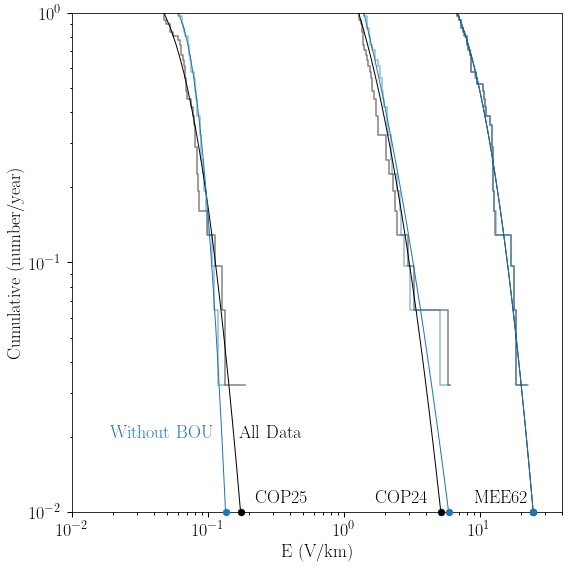

In [40]:
%%capture --no-display --no-stdout
fig, ax = plt.subplots(figsize=(8,8))

# sites_of_interest = (iCOP24, iCOP25, iVAQ58)
sites_of_interest = (iCOP24, iCOP25, iMEE62)

maxE_sorted = maxE_arr[sites_of_interest,:]

y100s = []

for i in sites_of_interest: 
    
    curr_data = np.sort(maxE_arr[i,:]/1000.)[-nyears:]
    
    fitting_func = fit_data(curr_data)
        
    ndata = len(fitting_func.parent_Fit.data)
    #ndata = len(curr_data)
    x100 = 0.01*nyears/ndata
    x = np.logspace(-3, 0)

    y = lognormal_ppf(x*nyears/ndata,
                      fitting_func.mu,
                      fitting_func.sigma,
                      xmin=fitting_func.xmin)
    y100 = lognormal_ppf(x100,
                         fitting_func.mu,
                         fitting_func.sigma,
                         xmin=fitting_func.xmin)
    
    print(MT_sites[i].name, ':', y100)

    y100s.append(y100)
    
    ax.plot(y, x, c='k', linewidth=1., zorder=2)
    ax.step(sorted(curr_data, reverse=True), (np.arange(len(curr_data))+1)/31, c='k', linewidth=1.5,
            alpha=0.5, where='post', zorder=1)
    ax.scatter(y100, 0.01, c='k', s=50, zorder=10, clip_on=False)
    
    curr_data = np.sort(maxE_arr2[i,:]/1000.)[-nyears:]
    
    fitting_func = fit_data(curr_data)
        
    ndata = len(fitting_func.parent_Fit.data)
    #ndata = len(curr_data)
    x100 = 0.01*nyears/ndata
    x = np.logspace(-3, 0)

    y = lognormal_ppf(x*nyears/ndata,
                      fitting_func.mu,
                      fitting_func.sigma,
                      xmin=fitting_func.xmin)
    y100 = lognormal_ppf(x100,
                         fitting_func.mu,
                         fitting_func.sigma,
                         xmin=fitting_func.xmin)
    
    print(MT_sites[i].name, ':', y100)

    y100s.append(y100)
    
    ax.plot(y, x, c='tab:blue', linewidth=1., zorder=2)
    ax.step(sorted(curr_data, reverse=True), (np.arange(len(curr_data))+1)/31, c='tab:blue', linewidth=1.5,
            alpha=0.5, where='post', zorder=1)
    ax.scatter(y100, 0.01, c='tab:blue', s=50, zorder=10, clip_on=False)

ax.text(2.2e-1, 0.011, 'COP25', fontsize=18)
ax.text(1.7, 0.011, 'COP24', fontsize=18)
ax.text(9., 0.011, 'MEE62', fontsize=18)

ax.text(0.019, 0.02, 'Without BOU', fontsize=18, color='tab:blue')
ax.text(0.17, 0.02, 'All Data', fontsize=18, color='k')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.01, 1)
ax.set_xlim(1e-2, 4e1)
ax.set_xlabel('E (V/km)')
ax.set_ylabel(r'Cumulative (number/year)')

ax.tick_params(which='minor', length=2.5, width=1, grid_alpha=1)
ax.tick_params(which='major', length=5, width=1, grid_alpha=1)

fig.savefig(fig_loc + 'secs_ccdf.pdf', bbox_inches='tight')

## Bootstrap confidence intervals

In [41]:
%%capture --no-display --no-stdout

n_sites = len(MT_sites)
n_samples = 100
E100 = np.zeros((n_sites, n_samples))
confidence_limits = np.zeros((n_sites, 5))

for i in range(n_sites):
# Printing if you want status updates
#     print(i, MT_sites[i].name)
    j = 0
    while j < n_samples:
        curr_data = np.sort(np.random.choice(maxE_arr[i, :], nyears, replace=True))/1000.
        
        fitting_func = fit_data(curr_data)        
        y100 = calc_100_year(fitting_func)
        if np.isnan(y100):
            continue

        E100[i, j] = y100
        j += 1
        
    # Have all samples drawn, so now compute the statistics
    sortedE = np.sort(E100[i, :])
    confidence_limits[i, :] = (np.quantile(sortedE, 0.05), np.quantile(sortedE, 0.32),
                               np.quantile(sortedE, 0.5),
                               np.quantile(sortedE, 0.68), np.quantile(sortedE, 0.95))
    
max_medians = confidence_limits[:, 2]
lower = confidence_limits[:, 0] / max_medians
upper = confidence_limits[:, 4] / max_medians
print("Confidence Limits:", np.nanmean(lower), np.nanmean(upper))

Confidence Limits: 0.7439864587765174 1.3766017505182029


## Hazard Maps

In [42]:
%%capture --no-display --no-stdout

n_sites = len(MT_sites)
n_trans_lines = len(df)
site_names = [x.name for x in MT_sites]
E100 = np.zeros(n_sites)
B100 = np.zeros(n_sites)
V100 = np.zeros(n_trans_lines)

with open('geoelectric_100year.csv', 'w') as f:
    print('Site,longitude,latitude,B data max,B 100-year,E data max,E 100-year', file=f)
    for i in range(n_sites):
        curr_data = np.sort(maxE_arr[i, :]/1000.)[-nyears:]
        # Use the bootstrap values we calculated previously
        y100 = confidence_limits[i, 2]
        E100[i] = y100
        E_data_max = np.max(curr_data)
        
        curr_data = np.sort(maxB_arr[i,:])[-nyears:]
        fitting_func = fit_data(curr_data)        
        y100 = calc_100_year(fitting_func)
        B100[i] = y100
        B_data_max = np.max(curr_data)
        print("{},{},{},{},{},{},{}".format(site_names[i], site_xys[i, 1], site_xys[i, 0], B_data_max, B100[i], E_data_max, E100[i]), file=f)
        
Z100 = E100/B100

iMAX = np.argmax(np.ma.masked_invalid(E100))
iMIN = np.argmin(np.ma.masked_invalid(E100))

print("Max E:", MT_sites[iMAX].name, E100[iMAX])
print("Min E:", MT_sites[iMIN].name, E100[iMIN])

for i in range(n_trans_lines):
    curr_data = np.sort(maxV_arr[i,:])[-nyears:]
    fitting_func = fit_data(curr_data)        
    y100 = calc_100_year(fitting_func)
    V100[i] = y100

Ebar100 = np.ma.masked_invalid(V100/(df['length']))

Max E: MEE62 27.21215359670033
Min E: IDK15 0.020727584979419934


In [43]:
linewidth_sizes = 2/(1-np.log10(Ebar100/np.nanmax(Ebar100)))
vmin, vmax = 0.1, 10
normEbar = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap = mpl.cm.get_cmap('inferno')
# Remove the bottom 10% of the cmap
cmapEbar = mpl.colors.LinearSegmentedColormap.from_list('Ebar', cmap(np.linspace(0.1, 1.0, 256)))
cmap = cmapEbar

vmin, vmax = 10, 923
cmapV = cmapEbar
normV = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)

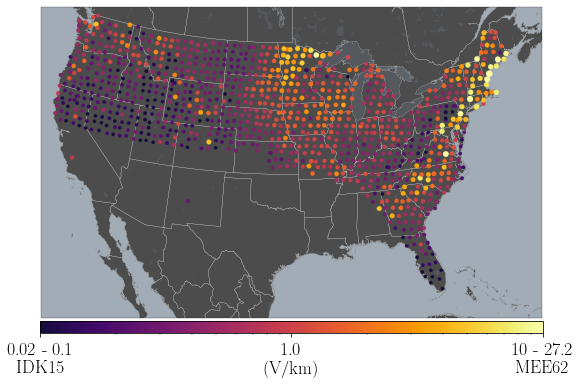

In [44]:
fig = plt.figure(figsize=(9, 6))

gs0 = gridspec.GridSpec(2, 1, height_ratios=[1, 0.04], hspace=0.02)
ax_cbar = plt.subplot(gs0[1]) # entire bottom

ax_efield = plt.subplot(gs0[0], projection=projection)
ax_efield.set_extent(plot_lon_bounds + lat_bounds, proj_data)

add_features_to_ax(ax_efield)

E100 = max_medians
sizes = 1/(1-np.log10(E100/np.nanmax(E100)))
ax_efield.scatter(site_xys[:,1], site_xys[:,0], c=E100, s=sizes*40, cmap=cmapEbar, norm=normEbar, transform=proj_data)

#--------------------------------
# Colorbar
#--------------------------------
sm = plt.cm.ScalarMappable(cmap=cmapEbar, norm=normEbar)
# Set scalar mappable array
sm._A = []
cbar = mpl.colorbar.Colorbar(ax=ax_cbar, mappable=sm, orientation='horizontal',
                             ticklocation='bottom', extend='neither')
cbar.set_ticks([0.1, 1., 10])
cbar.set_ticklabels(['{0:.2f} - 0.1\n{1}'.format(E100[iMIN], MT_sites[iMIN].name), '1.0\n(V/km)', '10 - {0:.1f}\n{1}'.format(E100[iMAX], MT_sites[iMAX].name)])
fig.savefig(fig_loc + 'geoelectric_field_100.png', bbox_inches='tight', dpi=200)

## Two panel plot (Voltage + $\bar{E}$)

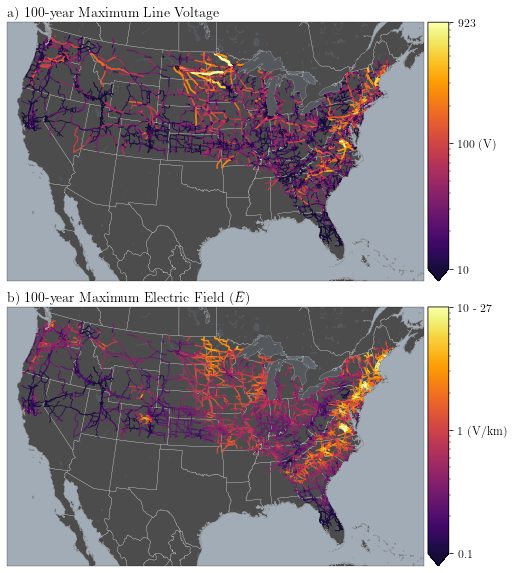

In [45]:
fig = plt.figure(figsize=(12, 10))

gs0 = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.1)

ax_voltage = plt.subplot(gs0[0, :], projection=projection)
ax_Ebar = plt.subplot(gs0[1, :], projection=projection)

for ax in [ax_voltage, ax_Ebar]:
    ax.set_extent(plot_lon_bounds + lat_bounds, proj_data)
    add_features_to_ax(ax)

#------------------
# Voltage
#------------------
coll = mpl.collections.LineCollection([np.array(linestring)[:, :2] for linestring in df['geometry']])
coll.set_array(np.ma.masked_invalid(np.abs(V100)))

coll.set_cmap(cmapV)
coll.set_norm(normV)
coll.set_transform(proj_data)

linewidth_sizes = 2.5/(1-np.log10(V100/np.nanmax(V100)))
coll.set_linewidths(linewidth_sizes)

ax_voltage.add_collection(coll)
divV = make_axes_locatable(ax_voltage)
ax_cbar = divV.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)

sm = mpl.cm.ScalarMappable(cmap=cmapV, norm=normV)
# Set scalar mappable array
sm._A = []
cbar = mpl.colorbar.Colorbar(ax=ax_cbar, mappable=sm, orientation='vertical',
                             ticklocation='right', extend='min')
# cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.tick_params(labelsize=12) #, direction='in')
# cbar.set_label(r'Voltage (V)', size=12)
# cbar.ax.xaxis.set_label_position('right')
cbar.set_ticks([10, 100, 923])
cbar.set_ticklabels(['10', '100 (V)', '923'])

#------------------
# Line Ebar
#------------------
coll = mpl.collections.LineCollection([np.array(linestring)[:, :2] for linestring in df['geometry']])
coll.set_array(np.ma.masked_invalid(np.abs(Ebar100)))

coll.set_cmap(cmapEbar)
coll.set_norm(normEbar)
coll.set_transform(proj_data)

linewidth_sizes = 2.5/(1-np.log10(Ebar100/np.nanmax(Ebar100)))
coll.set_linewidths(linewidth_sizes)

ax_Ebar.add_collection(coll)
divEbar = make_axes_locatable(ax_Ebar)
ax_cbar2 = divEbar.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)

sm = mpl.cm.ScalarMappable(cmap=cmapEbar, norm=normEbar)
# Set scalar mappable array
sm._A = []
cbar = mpl.colorbar.Colorbar(ax=ax_cbar2, mappable=sm, orientation='vertical',
                             ticklocation='right', extend='min')
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([0.1, 1, 10])
cbar.set_ticklabels(['0.1', '1 (V/km)', '10 - {0:d}'.format(int(np.round(E100[iMAX])))])

# -124 with mercator
labelx, labely = 0., 1.02
ax_voltage.text(labelx, labely, 'a) 100-year Maximum Line Voltage',
                transform=ax_voltage.transAxes, size=14)
ax_Ebar.text(labelx, labely, r'b) 100-year Maximum Electric Field ($\bar{E}$)',
                transform=ax_Ebar.transAxes, size=14)

fig.savefig(fig_loc + 'geoelectric_voltage_Ebar_100.png', bbox_inches='tight', dpi=200)

# Leave-one-out MT
Removing COP24 from the analysis

In [46]:
MT_sites2 = [site for site in MT_sites if site.name != "COP24"]
site_xys2 =  np.array([(site.latitude, site.longitude) for site in MT_sites2])

In [47]:
t1 = time.time()
#df.obj.apply(lambda x: x.set_nearest_sites(site_xys))
df2 = df.copy()
df2.obj.apply(lambda x: x.set_delaunay_weights(site_xys2))
print("Done filling interpolation weights: {0} s".format(time.time()-t1))

Done filling interpolation weights: 160.806458234787 s


In [48]:
oneday = datetime.timedelta(days=1)
twoday = 2*oneday

event_time = march89_storm
start_time, end_time = event_time-twoday, event_time+twoday
start_mag, end_mag = start_time-twoday, end_time+twoday

t0 = time.time()

obs_xy = []
B_obs = []

for name in obs_dict:
    dataset = obs_dict[name]

    data = dataset.loc[{'Time': slice(start_mag, end_mag)}].interpolate_na('Time')
    # No data here... skip ahead
    if len(data['Time']) == 0:
        continue

    data = np.array(data.loc[{'Time': slice(start_mag, end_mag)}].to_array().T)
    if np.any(np.isnan(data)):
        continue

    data = data - np.median(data, axis=0)
    obs_xy.append((dataset.Latitude, dataset.Longitude))
    B_obs.append(data)

obs_xy = np.squeeze(np.array(obs_xy))
B_obs = np.array(B_obs).swapaxes(0, 1)

print("Done reading in magnetic fields:", time.time()-t0)

# Now predict the magnetic field at all site locations
B_pred = calculate_SECS(B_obs, obs_xy, site_xys)
site_maxB = np.max(np.sqrt(B_pred[:,:,0]**2 + B_pred[:,:,1]**2), axis=0)
B_pred2 = calculate_SECS(B_obs, obs_xy, site_xys2)
site_maxB2 = np.max(np.sqrt(B_pred2[:,:,0]**2 + B_pred2[:,:,1]**2), axis=0)

print("Done predicting magnetic fields:", time.time()-t0)

# Use the magnetic field predictions to calculate Electric fields at all of those locations
# Removing one day on each side after calculations
min_per_day = 1440
E_pred = np.zeros((len(B_obs)-4*min_per_day, len(site_xys), 2))
for i, site in enumerate(MT_sites):
    Ex, Ey = site.convolve_fft(B_pred[:,i,0], B_pred[:,i,1], dt=60)
    E_pred[:,i,0] = Ex[2*min_per_day:-2*min_per_day]
    E_pred[:,i,1] = Ey[2*min_per_day:-2*min_per_day]
    
E_pred2 = np.zeros((len(B_obs)-4*min_per_day, len(site_xys2), 2))
for i, site in enumerate(MT_sites2):
    Ex, Ey = site.convolve_fft(B_pred2[:,i,0], B_pred2[:,i,1], dt=60)
    E_pred2[:,i,0] = Ex[2*min_per_day:-2*min_per_day]
    E_pred2[:,i,1] = Ey[2*min_per_day:-2*min_per_day]

print("Done calculating electric fields:", time.time()-t0)
# maximum electric field for each site
site_maxE = np.max(np.sqrt(E_pred[:,:,0]**2 + E_pred[:,:,1]**2), axis=0)
site_maxE2 = np.max(np.sqrt(E_pred2[:,:,0]**2 + E_pred2[:,:,1]**2), axis=0)

arr_delaunay = np.zeros(shape=(E_pred.shape[0], n_trans_lines))
for i, tLine in enumerate(df.obj):
    #if i % 1000 == 0:
    #    print(i, ':', time.time()-t0, 's')
    arr_delaunay[:,i] = tLine.calc_voltages(E_pred, how='delaunay')
line_maxV = np.nanmax(np.abs(arr_delaunay), axis=0)
print("Done calculating voltages:", time.time()-t0)

arr_delaunay2 = np.zeros(shape=(E_pred2.shape[0], n_trans_lines))
for i, tLine in enumerate(df2.obj):
    #if i % 1000 == 0:
    #    print(i, ':', time.time()-t0, 's')
    arr_delaunay2[:,i] = tLine.calc_voltages(E_pred2, how='delaunay')
line_maxV2 = np.nanmax(np.abs(arr_delaunay2), axis=0)
print("Done calculating voltages2:", time.time()-t0)

Done reading in magnetic fields: 5.517811059951782
Done predicting magnetic fields: 9.398359775543213
Done calculating electric fields: 24.94485902786255
Done calculating voltages: 491.21533608436584
Done calculating voltages2: 954.5311870574951


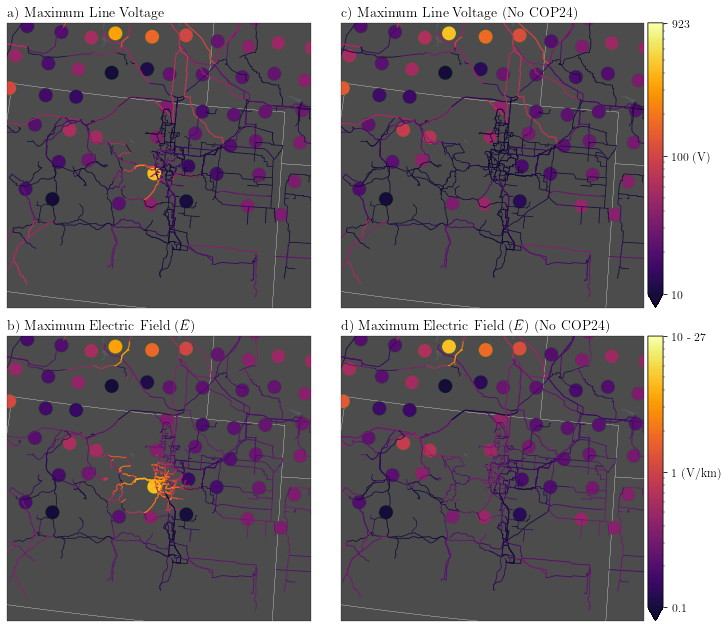

In [49]:
fig = plt.figure(figsize=(12, 11))

gs0 = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.1, wspace=0.05)

ax_voltage_orig = plt.subplot(gs0[0, 0], projection=projection)
ax_Ebar_orig = plt.subplot(gs0[1, 0], projection=projection)

ax_voltage = plt.subplot(gs0[0, 1], projection=projection)
ax_Ebar = plt.subplot(gs0[1, 1], projection=projection)

denver_lon, denver_lat = [-104.9903, 39.7392]
delta_lon, delta_lat = 3.5, 2.5
denver_bounds = [denver_lon - delta_lon, denver_lon + delta_lon, denver_lat - delta_lat, denver_lat + delta_lat]

for ax in [ax_voltage, ax_Ebar, ax_voltage_orig, ax_Ebar_orig]:
    ax.set_extent(denver_bounds, proj_data)
#     ax.set_extent([-108, -102] + [38, 42], proj_data)
    add_features_to_ax(ax)

#------------------
# Voltage
#------------------
coll = mpl.collections.LineCollection([np.array(linestring)[:, :2] for linestring in df['geometry']])
coll.set_array(np.ma.masked_invalid(np.abs(line_maxV2)))

coll.set_cmap(cmapV)
coll.set_norm(normV)
coll.set_transform(proj_data)

linewidth_sizes = 2.5/(1-np.log10(line_maxV2/np.nanmax(line_maxV2)))
coll.set_linewidths(linewidth_sizes)

ax_voltage.add_collection(coll)
divV = make_axes_locatable(ax_voltage)
ax_cbar = divV.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)

sm = mpl.cm.ScalarMappable(cmap=cmapV, norm=normV)
# Set scalar mappable array
sm._A = []
cbar = mpl.colorbar.Colorbar(ax=ax_cbar, mappable=sm, orientation='vertical',
                             ticklocation='right', extend='min')
# cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.tick_params(labelsize=12) #, direction='in')
# cbar.set_label(r'Voltage (V)', size=12)
# cbar.ax.xaxis.set_label_position('right')
cbar.set_ticks([10, 100, 923])
cbar.set_ticklabels(['10', '100 (V)', '923'])

#------------------
# Line Ebar
#------------------
coll = mpl.collections.LineCollection([np.array(linestring)[:, :2] for linestring in df['geometry']])
coll.set_array(np.ma.masked_invalid(np.abs(line_maxV2/df['length'])))

coll.set_cmap(cmapEbar)
coll.set_norm(normEbar)
coll.set_transform(proj_data)

linewidth_sizes = 2.5/(1-np.log10(line_maxV2/np.nanmax(line_maxV2)))
coll.set_linewidths(linewidth_sizes)

ax_Ebar.add_collection(coll)
divEbar = make_axes_locatable(ax_Ebar)
ax_cbar2 = divEbar.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)

sm = mpl.cm.ScalarMappable(cmap=cmapEbar, norm=normEbar)
# Set scalar mappable array
sm._A = []
cbar = mpl.colorbar.Colorbar(ax=ax_cbar2, mappable=sm, orientation='vertical',
                             ticklocation='right', extend='min')
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([0.1, 1, 10])
cbar.set_ticklabels(['0.1', '1 (V/km)', '10 - {0:d}'.format(int(np.round(E100[iMAX])))])

# -124 with mercator
labelx, labely = 0., 1.02
ax_voltage.text(labelx, labely, 'c) Maximum Line Voltage (No COP24)',
                transform=ax_voltage.transAxes, size=14)
ax_Ebar.text(labelx, labely, r'd) Maximum Electric Field ($\bar{E}$) (No COP24)',
                transform=ax_Ebar.transAxes, size=14)

sizes = 1/(1-np.log10(site_maxE2/np.nanmax(site_maxE2)))
for ax in [ax_voltage, ax_Ebar]:
    ax.scatter(site_xys2[:,1], site_xys2[:,0], c=site_maxE2/1000., s=200, edgecolor='g', cmap=cmapEbar, norm=normEbar, transform=proj_data)

#------------------
# Voltage
#------------------
coll = mpl.collections.LineCollection([np.array(linestring)[:, :2] for linestring in df['geometry']])
coll.set_array(np.ma.masked_invalid(np.abs(V100)))

coll.set_cmap(cmapV)
coll.set_norm(normV)
coll.set_transform(proj_data)

linewidth_sizes = 2.5/(1-np.log10(V100/np.nanmax(V100)))
coll.set_linewidths(linewidth_sizes)

ax_voltage_orig.add_collection(coll)

#------------------
# Ebar
#------------------
coll = mpl.collections.LineCollection([np.array(linestring)[:, :2] for linestring in df['geometry']])
coll.set_array(np.ma.masked_invalid(np.abs(Ebar100)))

coll.set_cmap(cmapEbar)
coll.set_norm(normEbar)
coll.set_transform(proj_data)

linewidth_sizes = 2.5/(1-np.log10(Ebar100/np.nanmax(Ebar100)))
coll.set_linewidths(linewidth_sizes)

ax_Ebar_orig.add_collection(coll)

# -124 with mercator
labelx, labely = 0., 1.02
ax_voltage_orig.text(labelx, labely, 'a) Maximum Line Voltage',
                transform=ax_voltage_orig.transAxes, size=14)
ax_Ebar_orig.text(labelx, labely, r'b) Maximum Electric Field ($\bar{E}$)',
                transform=ax_Ebar_orig.transAxes, size=14)

E100 = max_medians
for ax in [ax_voltage_orig, ax_Ebar_orig]:
    ax.scatter(site_xys[:,1], site_xys[:,0], c=E100, s=200, edgecolor='g', cmap=cmapEbar, norm=normEbar, transform=proj_data)

fig.savefig(fig_loc + 'geoelectric_voltage_Colorado_comparison.png', bbox_inches='tight', dpi=200)

## Plots for online/interactive use

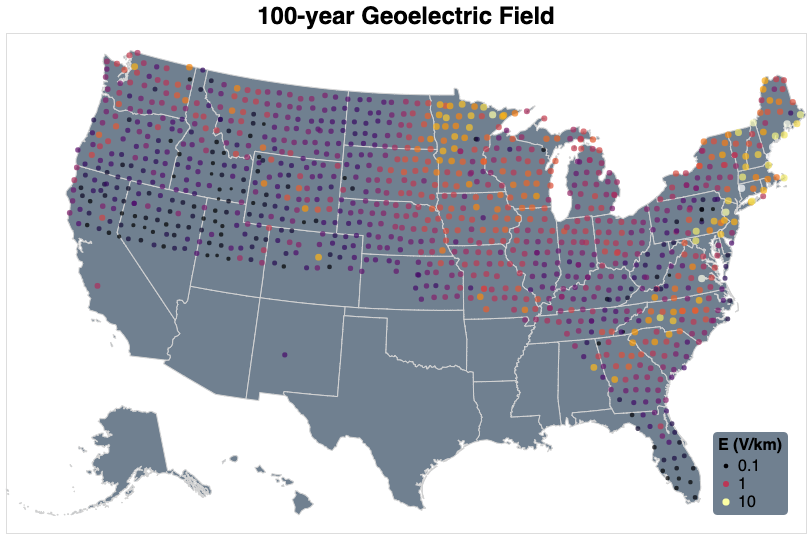

In [50]:
import altair as alt
from vega_datasets import data

states = alt.topo_feature(data.us_10m.url, feature='states')

# US states background
background = alt.Chart(states).mark_geoshape(
    fill='slategray',
    stroke='lightgray'
).properties(
    width=800,
    height=500
).project('albersUsa')

df_E100 = pd.read_csv('geoelectric_100year.csv')
# positions on top of the background
points = alt.Chart(df_E100, title=alt.TitleParams('100-year Geoelectric Field', fontSize=24)).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.Size('E 100-year:Q', scale=alt.Scale(type='log', range=(20, 50), domain=(0.1, 10))),
    color=alt.Color('E 100-year:Q',
                    scale=alt.Scale(scheme='inferno', type='log', domain=(0.1, 10)),
                    legend=alt.Legend(title="E (V/km)", tickCount=2, fillColor='slategray',
                                      cornerRadius=5, orient='bottom-right', columns=1,
                                      labelFontSize=16, titleFontSize=16, padding=5)),
    tooltip=['Site',
             alt.Tooltip('latitude:Q', format='.2f'),
             alt.Tooltip('longitude:Q', format='.2f'),
             alt.Tooltip('E 100-year:Q', format='.2f'),
             alt.Tooltip('E data max:Q', format='.2f')],
)

(background + points).save('../E100_interactive.html')
(background + points)